<a href="https://colab.research.google.com/github/MichalRyszardWojcik/hello-world/blob/master/2020_09_16_grawszachy_64tokens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 0: Import and Install

In [ ]:
import os
import numpy as np
! pip install -q -U trax
import trax

import chess
import chess.pgn
import chess.svg

from IPython.core.display import HTML
from IPython.display import Javascript

# Section 1: Python Chess vs Our Tokens and Chess GUI

In [29]:
def move2tokens(move): return [move.from_square,move.to_square]

def tokens2move(tokens):
  from_square = tokens[0]
  to_square = tokens[1]
  if from_square == 64: return chess.Move(0,0)
  return chess.Move(from_square,to_square)

def game2tokens(game):
  tokens = []
  line = game.main_line()
  for move in line: tokens += move2tokens(move)
  return tokens

def tokens2board(tokens):
  board = chess.Board()
  for i in range(len(tokens)//2):
    move = tokens2move(tokens[2*i:2*i+2])
    board.push(move)
  return board

def tokens2apronus(tokens):
  moves = []
  for i in range(len(tokens)//2):
    move = tokens2move(tokens[2*i:2*i+2])
    move = move.uci()
    moves.append(move)
  m = '_'.join(moves)
  return 'https://www.apronus.com/chess/pgnviewer/?m=' + m

def inputmoves_to_tokens(moves):
  tokens = []
  moves = moves.split('_')
  for move in moves:
    move = chess.Move.from_uci(move)
    token = move2tokens(move)
    tokens += token
  return tokens

def displaygame(tokens):
  print(tokens2apronus(tokens))
  board = chess.Board()
  html = ''
  for i in range(len(tokens)//2):
    move = tokens2move(tokens[2*i:2*i+2])
    if (move.from_square == 64):
      board.clear()
      header = 'Game Over'
    else:
      legal = move in board.legal_moves
      if legal:
        legal = 'legal'
        style = ''
      else:
        legal = 'illegal'
        style = 'background:red; color:yellow; font-weight:bold;'
      move_number = str(i//2 + 1) + '.'
      if i%2==1: move_number += '..'
      header = '<div style="'+style+'">after '+legal+' '+move_number+' '+move.uci()+'</div>'
      board.push(move)
    style = 'display:inline-block; width:20em; text-align:center; margin-bottom: 1em;'
    html += '<div style="'+style+'">'+header+chess.svg.board(board)+'</div>'
  display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
  display(HTML(html))

def usermove(board):
  while True:
    print('Type your move in UCI format:')
    usermove = input()
    if usermove == '': return ''
    move = chess.Move.from_uci(usermove)
    if move in board.legal_moves: return move;
    print('You have typed an illegal move.')

# Section 2: PGN Import and Tokenization

(1) We download the PGN file https://chessdiagram.online/games/lichess_db_standard_rated_2014-07.zip from my own server, originally taken from https://database.lichess.org/. It has almost a million games played by humans in July 2014 on Lichess. It is possible to get more games from there.

(2) Next we tokenize this PGN file and save as "/content/64tokens1000k.txt".

(3) But tokenization takes a long time, longer than training a large model. Therefore, steps (1) and (2) are skipped by default (commented out) and instead we load the ready-made tokenized database from https://chessdiagram.online/games/64tokens1000k.zip


In [ ]:
g_max_ile = 1100*1000
def tokenize(input_pgn_file,output_file):
  ile = 0
  while True:
    game = chess.pgn.read_game(pgn)
    if game == None:
      input_pgn_file.close()
      output_file.close()
      return ile
    if len(game.errors) > 0: print(game.errors)
    game = game2tokens(game)
    if len(game) >= 24:
      game = str(game).strip('[]')
      output_file.write(game)
      ile += 1
      if ile % 1000 == 0: print(f'{ile//1000}K games tokenized')
      if ile == g_max_ile:
        input_pgn_file.close()
        output_file.close()
        return ile
      else:
        output_file.write('\n')

In [ ]:
#!wget https://chessdiagram.online/games/lichess_db_standard_rated_2014-07.zip
#!unzip lichess_db_standard_rated_2014-07.zip

In [ ]:
#pgn = open('lichess_db_standard_rated_2014-07.pgn','r') # 1,048,440 games
#tokens = open('/content/64tokens1000k.txt','w')
#ile = tokenize(pgn,tokens)
#ile

In [3]:
!wget https://chessdiagram.online/games/64tokens1000k.zip
!unzip 64tokens1000k.zip

--2020-09-16 09:53:49--  https://chessdiagram.online/games/64tokens1000k.zip
Resolving chessdiagram.online (chessdiagram.online)... 184.154.45.213
Connecting to chessdiagram.online (chessdiagram.online)|184.154.45.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115683433 (110M) [application/zip]
Saving to: ‘64tokens1000k.zip’

64tokens1000k.zip   100%[===================>] 110.32M  18.0MB/s    in 9.7s    

2020-09-16 09:54:00 (11.4 MB/s) - ‘64tokens1000k.zip’ saved [115683433/115683433]

Archive:  64tokens1000k.zip
  inflating: 64tokens1000k.txt       


In [4]:
def load_tokenized_games(tokens_file):
  tokenized_games = []
  for line in tokens_file:
    pregame = line.split(", ")
    game = []
    for x in pregame:
      game.append(int(x))
    if len(game) >= 48: tokenized_games.append(game)
  return tokenized_games

In [5]:
#tokens = open('/content/tokens.txt','r')
tokens = open('/content/64tokens1000k.txt','r')
tokenized_games = load_tokenized_games(tokens)
ile = len(tokenized_games)
print(ile) #979685 almost a million games

979693


The global variable <code>tokenized_games</code> is a list of tokenized games from the PGN database. It is used in the training process in the next section.

# Section 3: Training the model

The training input is compoed of batches of random games. The batch size is **128 games** and the maximum game length is **60 half-moves**, which is 30 White moves and 30 Black moves.

In [6]:
game_length = 60
g_vocab_size = 65
# each square is a token 0--63 but there is also the end-of-game token 64

This section relies on the global variable <code>tokenized_games</code> prepared in the previous section.

In [7]:
g_ile = len(tokenized_games)
def random_tokenized_game():
  i = np.random.randint(0, g_ile)
  return tokenized_games[i]

In [ ]:
displaygame(random_tokenized_game())

In [37]:
def training_input(batch_size, length):
  while True:
    shape = (batch_size,length)
    games = np.ones(shape, np.int32) * 64
    for y in range(batch_size):
      game = random_tokenized_game()[0:length-2] # leaves two 64s at the end
      for x in range( min( len(game), length ) ):
        games[y,x] = game[x]
    inputs = games
    targets = games
    loss_weights = np.ones(shape, np.int32)
    yield (inputs,targets,loss_weights)

trax_inputs = trax.data.inputs.Inputs(lambda _: training_input(batch_size=128, length = 2*game_length + 2))

In [38]:
def perform_training(lm,n_epochs,train_steps,eval_steps):
  output_dir = os.path.expanduser('~/train_dir/')
  !rm -f ~/train_dir/model.pkl.gz  # Remove old model.
  trainer = trax.supervised.Trainer(
      model=lm,
      loss_fn=trax.layers.CrossEntropyLoss(),
      optimizer=trax.optimizers.Adafactor,  # Change optimizer params here.
      lr_schedule=trax.lr.warmup_and_rsqrt_decay(400, 0.01),  # Change lr schedule here.
      inputs=trax_inputs,
      output_dir=output_dir)
  for _ in range(n_epochs):
    trainer.train_epoch(train_steps, eval_steps)

In [ ]:
def Chess_transformer_lm_128_256_2_2(mode='train'):
  return trax.models.TransformerLM(  
          d_model=128,
          d_ff=256,
          n_heads=2,
          n_layers=2, 
          vocab_size= g_vocab_size,
          mode=mode)

def perform_training_10_500_2_128_256_2_2():
  perform_training(
    lm=Chess_transformer_lm_128_256_2_2,
    n_epochs = 10,
    train_steps = 500,
    eval_steps = 2)

perform_training_10_500_2_128_256_2_2()


In [40]:
class ChessModel():
  lm = None
  path = None

model_10_500_2_128_256_2_2 = ChessModel()
model_10_500_2_128_256_2_2.lm = Chess_transformer_lm_128_256_2_2('predict')
model_10_500_2_128_256_2_2.path = '/root/train_dir/model.pkl.gz'

## Section 4.1: Training the stronger model: 64tokens-10_500_2_512_2048_4_8

In [ ]:
def Chess_transformer_lm_512_2048_4_8(mode='train'):
  return trax.models.TransformerLM(  
        d_model=512,
        d_ff=2048,
        n_heads=4,
        n_layers=8, 
        vocab_size= g_vocab_size,
        mode=mode)
def perform_training_10_500_2_512_2048_4_8():
  perform_training(
    lm=Chess_transformer_lm_512_2048_4_8,
    n_epochs = 10,
    train_steps = 500,
    eval_steps = 2)

perform_training_10_500_2_512_2048_4_8()

Training took 2 hours and 20 minutes.
<pre><code>Step    500: Ran 500 train steps in 938.18 secs
Step    500: Evaluation
Step    500: train                   accuracy |  0.49279588
Step    500: train                       loss |  1.73431218
Step    500: train         neg_log_perplexity | -1.73431218
Step    500: train          sequence_accuracy |  0.00000000
Step    500: train weights_per_batch_per_core |  15616.00000000
Step    500: eval                    accuracy |  0.47755510
Step    500: eval                        loss |  1.78947043
Step    500: eval          neg_log_perplexity | -1.78947043
Step    500: eval           sequence_accuracy |  0.00000000
Step    500: eval  weights_per_batch_per_core |  15616.00000000
Step    500: Finished evaluation

Step   1000: Ran 500 train steps in 832.01 secs
Step   1000: Evaluation
Step   1000: train                   accuracy |  0.53621292
Step   1000: train                       loss |  1.50503480
Step   1000: train         neg_log_perplexity | -1.50503480
Step   1000: train          sequence_accuracy |  0.00000000
Step   1000: train weights_per_batch_per_core |  15616.00000000
Step   1000: eval                    accuracy |  0.53192246
Step   1000: eval                        loss |  1.52082586
Step   1000: eval          neg_log_perplexity | -1.52082586
Step   1000: eval           sequence_accuracy |  0.00000000
Step   1000: eval  weights_per_batch_per_core |  15616.00000000
Step   1000: Finished evaluation

Step   1500: Ran 500 train steps in 830.53 secs
Step   1500: Evaluation
Step   1500: train                   accuracy |  0.55122954
Step   1500: train                       loss |  1.41754270
Step   1500: train         neg_log_perplexity | -1.41754270
Step   1500: train          sequence_accuracy |  0.00000000
Step   1500: train weights_per_batch_per_core |  15616.00000000
Step   1500: eval                    accuracy |  0.55049312
Step   1500: eval                        loss |  1.41054130
Step   1500: eval          neg_log_perplexity | -1.41054130
Step   1500: eval           sequence_accuracy |  0.00000000
Step   1500: eval  weights_per_batch_per_core |  15616.00000000
Step   1500: Finished evaluation

Step   2000: Ran 500 train steps in 829.54 secs
Step   2000: Evaluation
Step   2000: train                   accuracy |  0.57277799
Step   2000: train                       loss |  1.32309794
Step   2000: train         neg_log_perplexity | -1.32309794
Step   2000: train          sequence_accuracy |  0.00000000
Step   2000: train weights_per_batch_per_core |  15616.00000000
Step   2000: eval                    accuracy |  0.57655615
Step   2000: eval                        loss |  1.31939673
Step   2000: eval          neg_log_perplexity | -1.31939673
Step   2000: eval           sequence_accuracy |  0.00000000
Step   2000: eval  weights_per_batch_per_core |  15616.00000000
Step   2000: Finished evaluation

Step   2500: Ran 500 train steps in 829.58 secs
Step   2500: Evaluation
Step   2500: train                   accuracy |  0.57505131
Step   2500: train                       loss |  1.29977310
Step   2500: train         neg_log_perplexity | -1.29977310
Step   2500: train          sequence_accuracy |  0.00000000
Step   2500: train weights_per_batch_per_core |  15616.00000000
Step   2500: eval                    accuracy |  0.57335424
Step   2500: eval                        loss |  1.30683231
Step   2500: eval          neg_log_perplexity | -1.30683231
Step   2500: eval           sequence_accuracy |  0.00000000
Step   2500: eval  weights_per_batch_per_core |  15616.00000000
Step   2500: Finished evaluation

Step   3000: Ran 500 train steps in 829.45 secs
Step   3000: Evaluation
Step   3000: train                   accuracy |  0.57866931
Step   3000: train                       loss |  1.28477561
Step   3000: train         neg_log_perplexity | -1.28477561
Step   3000: train          sequence_accuracy |  0.00000000
Step   3000: train weights_per_batch_per_core |  15616.00000000
Step   3000: eval                    accuracy |  0.58475286
Step   3000: eval                        loss |  1.26384091
Step   3000: eval          neg_log_perplexity | -1.26384091
Step   3000: eval           sequence_accuracy |  0.00000000
Step   3000: eval  weights_per_batch_per_core |  15616.00000000
Step   3000: Finished evaluation

Step   3500: Ran 500 train steps in 828.99 secs
Step   3500: Evaluation
Step   3500: train                   accuracy |  0.59009993
Step   3500: train                       loss |  1.23472798
Step   3500: train         neg_log_perplexity | -1.23472798
Step   3500: train          sequence_accuracy |  0.00000000
Step   3500: train weights_per_batch_per_core |  15616.00000000
Step   3500: eval                    accuracy |  0.59451842
Step   3500: eval                        loss |  1.22385108
Step   3500: eval          neg_log_perplexity | -1.22385108
Step   3500: eval           sequence_accuracy |  0.00000000
Step   3500: eval  weights_per_batch_per_core |  15616.00000000
Step   3500: Finished evaluation

Step   4000: Ran 500 train steps in 828.64 secs
Step   4000: Evaluation
Step   4000: train                   accuracy |  0.59868085
Step   4000: train                       loss |  1.20355105
Step   4000: train         neg_log_perplexity | -1.20355105
Step   4000: train          sequence_accuracy |  0.00000000
Step   4000: train weights_per_batch_per_core |  15616.00000000
Step   4000: eval                    accuracy |  0.59868085
Step   4000: eval                        loss |  1.20055294
Step   4000: eval          neg_log_perplexity | -1.20055294
Step   4000: eval           sequence_accuracy |  0.00000000
Step   4000: eval  weights_per_batch_per_core |  15616.00000000
Step   4000: Finished evaluation

Step   4500: Ran 500 train steps in 828.92 secs
Step   4500: Evaluation
Step   4500: train                   accuracy |  0.61043167
Step   4500: train                       loss |  1.16270351
Step   4500: train         neg_log_perplexity | -1.16270351
Step   4500: train          sequence_accuracy |  0.00000000
Step   4500: train weights_per_batch_per_core |  15616.00000000
Step   4500: eval                    accuracy |  0.59698391
Step   4500: eval                        loss |  1.19752789
Step   4500: eval          neg_log_perplexity | -1.19752789
Step   4500: eval           sequence_accuracy |  0.00000000
Step   4500: eval  weights_per_batch_per_core |  15616.00000000
Step   4500: Finished evaluation

Step   5000: Ran 500 train steps in 830.29 secs
Step   5000: Evaluation
Step   5000: train                   accuracy |  0.61491418
Step   5000: train                       loss |  1.14494586
Step   5000: train         neg_log_perplexity | -1.14494586
Step   5000: train          sequence_accuracy |  0.00000000
Step   5000: train weights_per_batch_per_core |  15616.00000000
Step   5000: eval                    accuracy |  0.61052769
Step   5000: eval                        loss |  1.14564824
Step   5000: eval          neg_log_perplexity | -1.14564824
Step   5000: eval           sequence_accuracy |  0.00000000
Step   5000: eval  weights_per_batch_per_core |  15616.00000000
Step   5000: Finished evaluation</code></pre>

## Section 4.2: Downloading the stronger model: 64tokens-10_500_2_512_2048_4_8

In [ ]:
!wget https://chessdiagram.online/games/model-64tokens-10_500_2_512_2048_4_8.pkl.gz

# '/content/model-64tokens-10_500_2_512_2048_4_8.pkl.gz'

# Section 4: Testing the model

We use three ways to interact with our chess playing models:
1. <code>illegalgame(firstmoves,model,final_fullmove_number)</code>
<br>displays a game starting with <code>firstmoves</code> followed by <code>model</code>-generated (not necessarily) legal moves
2. <code>legalgame(firstmoves,model,final_fullmove_number)</code>
<br>displays a game starting with <code>firstmoves</code> followed by <code>model</code>-generated legal moves
3. <code>playchess(firstmoves,model)</code>
<br>lets the user play against the <code>model</code> from the position after <code>firstmoves</code>

The string <code>firstmoves</code> is a sequence of UCI formatted moves separated by the underscore, for example <code>firstmoves = 'f2f3_e7e5_g2g4_d8h4'</code>.

The argument <code>model</code> is an object with two properties:
1. <code>model.lm</code> is the result of calling <code>trax.models.TransformerLM(mode='predict')</code>
2. <code>model.path</code> is the path to the model file 

Note that the argument <code>final_fullmove_number</code>  is used to limit the number of moves outputted by the model.

These functions output the games as links to a chess editor,<br>
for example https://www.apronus.com/chess/pgnviewer/?m=f2f3_e7e5_g2g4_d8h4
<br>This allows us to view the games move by move on an interactive chessboard and to export them as PGN. The tails of these links can also be used as the input argument <code>firstmoves</code>.


??????????????????????????????????????????????
I cannot modify these functions for moves composed of two tokens.
??????????????????????????????????????????????
The following two functions <code>autoregressive_sample_stream</code> and <code>autoregressive_sample</code><br>
from https://github.com/google/trax/blob/master/trax/supervised/decoding.py
<br>are modified to ensure that the model produces only legal chess moves.

In [ ]:
from trax import layers as tl

def autoregressive_sample_stream(model, inputs=None,
                                 batch_size=1, temperature=1.0,
                                 start_id=0, accelerate=True):
  if inputs is not None and inputs.shape[0] != batch_size:
    raise ValueError(f'Inputs batch size ({inputs.shape[0]}) does not match '
                     f'batch_size arg ({batch_size}.')

  fast_model = tl.Accelerate(model) if accelerate else model
  start_symbol = np.full((batch_size, 1), start_id, dtype=np.int32)
  if model.n_in == 1 and inputs is not None:
    current_symbols = np.concatenate([start_symbol, inputs], axis=1)
  else:
    current_symbols = start_symbol

  tokens = inputs.flatten()
  board = tokens2board(tokens)

  while True:
    if model.n_in > 1 and inputs is not None:
      logits = fast_model((inputs, current_symbols))[0]
    else:
      logits = fast_model(current_symbols)
    #sample = tl.logsoftmax_sample(logits[:, -1, :], temperature=temperature)
    x = logits[:, -1, :].flatten()
    positive = np.exp(x)
    legalmoves = board.legal_moves
    for x in range(len(positive)):
      if token2move(x) not in legalmoves:
        positive[x] = 0
    next_token = np.argmax(positive)
    board.push(token2move(next_token))
    sample = next_token
    sample = np.array(sample).reshape((1,1))
    yield sample
    # NOTE: Because the model is autoregressive and in 'predict' mode, its
    # history is cached in the model state and the next input is the single
    # symbol just sampled.
    current_symbols = sample[:, None]


def autoregressive_sample(model, inputs=None,
                          batch_size=1, temperature=1.0,
                          start_id=0, eos_id=1, max_length=100,
                          accelerate=True):
  result = []
  eos_seen = []
  counter = 0
  for sample in autoregressive_sample_stream(
      model, inputs, batch_size=batch_size, temperature=temperature,
      start_id=start_id, accelerate=accelerate):
    sample = sample[:, None]
    result.append(sample)
    counter += 1
    if counter >= max_length:
      return np.concatenate(result, axis=1)
    # Check at which batch positions have we already encountered EOS.
    for j in range(batch_size):
      if int(sample[j, 0]) == eos_id:
        eos_seen.append(j)
    # If EOS has been seen on all positions, stop.
    if all([j in eos_seen for j in range(batch_size)]):
      return np.concatenate(result, axis=1)
  return np.concatenate(result, axis=1)

In [51]:
def _displaygame(legal,firstmoves,model,final_fullmove_number):
  firstmoves = inputmoves_to_tokens(firstmoves)
  board = tokens2board(firstmoves)
  display(board)
  input = np.array(firstmoves).reshape((1,len(firstmoves)))

  length = final_fullmove_number * 4 - len(firstmoves) # max number of tokens to output

  print(f'Using model: {model.path}')
  predict_model = model.lm
  predict_signature = trax.shapes.ShapeDtype((1,1), dtype=np.int32)
  predict_model.init_from_file(model.path,weights_only=True, input_signature=predict_signature)
  if legal:
    played =                          autoregressive_sample(predict_model, input, temperature=0.0, max_length=length, eos_id = 64)
  else:
    played = trax.supervised.decoding.autoregressive_sample(predict_model, input, temperature=0.0, max_length=length, eos_id = 64)

  gamestart = input.flatten()
  gameplayed = played.flatten()
  game = np.concatenate((gamestart,gameplayed))
  displaygame(game)

def illegalgame(firstmoves,model,length=game_length):
  _displaygame(False,firstmoves,model,length)
def legalgame(firstmoves, model, length=game_length):
  _displaygame(True,firstmoves,model,length)

In [62]:
model_64tokens_10_500_2_512_2048_4_8 = ChessModel()
model_64tokens_10_500_2_512_2048_4_8.lm = Chess_transformer_lm_512_2048_4_8('predict')
model_64tokens_10_500_2_512_2048_4_8.path = '/content/model-64tokens-10_500_2_512_2048_4_8.pkl.gz'

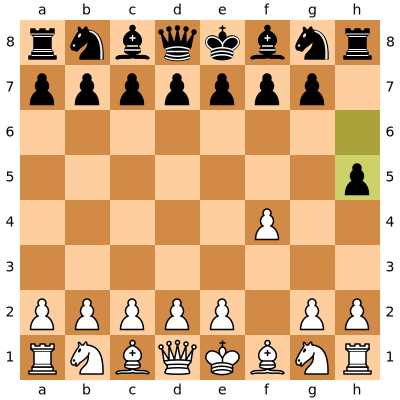

Using model: /content/model-64tokens-10_500_2_512_2048_4_8.pkl.gz
https://www.apronus.com/chess/pgnviewer/?m=f2f3_h7h6_f3f4_h6h5_e2e3_h5h4_g2g3_h4g3_h2g3_d7d6_f1g2_b8c6_d2d3_c8g4_g1e2_g4f3_g2f3_e7e5_f4e5_d6e5_e3e4_d8d7_c1f4_e8c8_b1c3_f7f6_d1d2_g7g5_f4e3_f8b4_e1c1_b4c3_d2c3_g8e7_d1f1_e7g6_f1f2_g6f4_e3f4_g5f4_g3f4_e5f4_e2f4_d7g4_f4e6_g4f3_f2f3_d8e8_e6g7_e8e3_c1b1_e3d3_g7f5_d3d2_f5g7_d2b2_g7f5_c8b8_f5g7_h8e8


<IPython.core.display.Javascript object>

In [65]:
illegalgame('f2f3_h7h6_f3f4_h6h5',model_64tokens_10_500_2_512_2048_4_8,30)

In [ ]:
legalgame('e2e4_e7e5',model_2020_09_09_04,41)

In [ ]:
def _legal_token_after_tokens(firstmoves,model):
  input = np.array(firstmoves).reshape((1,len(firstmoves)))
  predict_model = model.lm
  predict_signature = trax.shapes.ShapeDtype((1,1), dtype=np.int32)
  predict_model.init_from_file(model.path,weights_only=True, input_signature=predict_signature)
  return autoregressive_sample(predict_model, input, temperature=0.0, max_length=1, eos_id = 0)

def playchess(moves,model):
  board = chess.Board()
  tokens = []
  if moves != '':
    moves = moves.split('_')
    for move in moves:
      move = chess.Move.from_uci(move)
      board.push(move)
      token = move2token(move)
      tokens.append(token)
  display(board)
  while not board.is_game_over():
    move = usermove(board)
    if move == '': return
    board.push(move)
    display(board)
    tokens.append(move2token(move))
    if not board.is_game_over():
      token = _legal_token_after_tokens(tokens,model)
      token = token.flatten()[0]
      tokens.append(token)
      move = token2move(token)
      board.push(move)
      print(f'Using model: {model.path}')
      display(board)
      print(tokens2apronus(tokens))

In [ ]:
playchess('',model_2020_09_04)

In [ ]:
playchess('',model_2020_09_07)

# Section 5: Notes and observations

The weaker engine fails to capture the queen after<br>
https://www.apronus.com/chess/pgnviewer/?m=e2e4_e7e5_f1c4_g8f6_d1h5_g7g6_b1c3_f8g7

In [ ]:
playchess('e2e4_e7e5_f1c4_g8f6',model_2020_09_04)

The stronger model captured the queen at h5:<br>
https://www.apronus.com/chess/pgnviewer/?m=e2e4_e7e5_f1c4_f8c5_b1c3_g8f6_d1h5_f6h5

In [ ]:
legalgame('e2e4_e7e5_f1c4_g8f6_d1h5',model_2020_09_07,1)

(It played quite well despite leaving the bishop c5 unprotected and blundering the queen at h4:
https://www.apronus.com/chess/pgnviewer/?m=e2e4_e7e5_f1c4_f8c5_b1c3_g8f6_d1h5_f6h5_g2g4_h5f4_c3a4_e8g8_a4c5_d7d6_a2a4_c8g4_c5e6_g4e6_c4f1_b8c6_a4a5_c6d4_h2h4_d4c2_e1d1_c2a1_a5a6_b7b6_b2b4_d8h4_h1h4_f7f5)



The stronger model is much more interesting after 1.Nh3. The old model ignored this move and imitated a game with no regard to the knight having moved to h3. But the stronger model actually uses this knight to go to f7:
https://www.apronus.com/chess/pgnviewer/?m=g1h3_e7e5_h3g5_d7d5_g5f7_e8f7_e2e3_g8f6_b1c3_f8b4_a2a3_b4c3_d2c3_e5e4_f1e2_h8e8_e1g1_f7g8_c1d2_c7c6_c3c4_c8e6_c4d5_c6d5_c2c4_b8c6_c4d5_e6d5_d2c3_d5d4_c3d2_d4e3_d2e3_e8e3_f2e3_e8e3_d1c2_c6d4_c2c3_d4e2_g1h1_e2g3_h2g3_f6e4_h1h2_g3f1_a1f1_e4g3_h2g3_f1g3_f1f4_g3f1_f4f1_g3f1_d1f1_g3f1_0000


In [ ]:
legalgame('g1h3',model_2020_09_04,7)

In [ ]:
legalgame('g1h3',model_2020_09_07,7)